In [55]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
from typing import Literal, Tuple, Dict
from dataclasses import dataclass


sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 22})
torch.manual_seed(42)
np.random.seed(42)


data_path = Path.cwd().parent / "classification_data"
ett_path = data_path / "ETTh1"
weather_path = data_path / "weather"
exchange_path = data_path / "Exchange"

<h2> Visualizing predictions </h2>

In [56]:
@dataclass
class CLSData:
    x: np.ndarray
    y: np.ndarray
    preds: np.ndarray
    mse: pd.DataFrame
    best_idx: pd.DataFrame
    id2label: dict
    name: str


def load_cls_data(path: Path, split: Literal["train", "test", "val"], name="data", include_mean=False) -> CLSData:
    x = np.load(path / f"{split}_inputs.npy")
    y = np.load(path / f"{split}_outputs.npy")

    mse = np.load(path / f"{split}_mse.npy")
    preds = np.load(path / f"{split}_predictions.npy")

    with open(weather_path / "model_order.json") as f:
        id2label = json.load(f)
        id2label = {int(k): v for k, v in id2label.items()}

    if include_mean:
        mean_preds = preds.mean(0)
        mean_mse = ((y - mean_preds)**2).mean(1)
        mse = np.concatenate((mse, mean_mse[None, :]))
        preds = np.concatenate((preds, mean_preds[None, :, :]))
        id2label[len(id2label)] = "Mean"

    best_idx = mse.argmin(0)
    return CLSData(x, y, preds, mse, best_idx, id2label, name)

In [57]:
weather_train_data = load_cls_data(weather_path, "train", "Weather train data")
weather_val_data = load_cls_data(weather_path, "val", "Weather val data")
weather_test_data = load_cls_data(weather_path, "test", "Weather test data")
weather_test_data.x.shape, weather_test_data.y.shape, weather_test_data.preds.shape, weather_test_data.mse.shape, weather_test_data.best_idx.shape

((10444, 96, 21),
 (10444, 96, 21),
 (7, 10444, 96, 21),
 (7, 10444, 21),
 (10444, 21))

In [58]:
ett_train_data = load_cls_data(ett_path, "train", "ETTh train data")
ett_val_data = load_cls_data(ett_path, "val", "ETTh val data")
ett_test_data = load_cls_data(ett_path, "test", "ETTh test data")
ett_test_data.x.shape, ett_test_data.y.shape, ett_test_data.preds.shape, ett_test_data.mse.shape, ett_test_data.best_idx.shape

((2785, 96, 7), (2785, 96, 7), (7, 2785, 96, 7), (7, 2785, 7), (2785, 7))

In [59]:
exchange_train_data = load_cls_data(exchange_path, "train", "Exchange train data")
exchange_val_data = load_cls_data(exchange_path, "val", "Exchange val data")
exchange_test_data = load_cls_data(exchange_path, "test", "Exchange test data")
exchange_test_data.x.shape, exchange_test_data.y.shape, exchange_test_data.preds.shape, exchange_test_data.mse.shape, exchange_test_data.best_idx.shape

((1422, 96, 8), (1422, 96, 8), (7, 1422, 96, 8), (7, 1422, 8), (1422, 8))

In [60]:
weather_test_data.id2label

{0: 'Crossformer',
 1: 'DLinear',
 2: 'PatchTST',
 3: 'TimeMixer',
 4: 'TimeXer',
 5: 'TimesNet',
 6: 'iTransformer'}

In [61]:
import numpy as np
import matplotlib.pyplot as plt


def plot_slice_preds(cls_data: CLSData, slice_idx, feature_idx=0):
    inp = cls_data.x[slice_idx, :, feature_idx]
    out = cls_data.y[slice_idx, :, feature_idx]
    preds = cls_data.preds[:, slice_idx, :, feature_idx]
    mse_per_model = ((preds - out)**2).mean(axis=1)

    best_idx = cls_data.best_idx[slice_idx, feature_idx]
    best_model = cls_data.id2label[best_idx]

    t_in = np.arange(len(inp))
    t_out = np.arange(len(inp), len(inp) + len(out))

    plt.figure()
    plt.plot(t_in, inp, color='tab:gray', linewidth=2, label='Input (history)')
    plt.axvline(x=len(inp)-0.5, color='black', linestyle='--',
                alpha=0.7, label='Forecast start')
    plt.plot(t_out, out, color='tab:green', linewidth=3,
             label='Ground truth', solid_capstyle='butt')

    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    for i in range(preds.shape[0]):
        label = f'{cls_data.id2label[i]} (MSE = {mse_per_model[i]:.4f})'
        plt.plot(t_out, preds[i], color=colors[i], linestyle='--', linewidth=2,
                 label=label, alpha=0.9)

    plt.xlabel('Time step')
    plt.ylabel(f'Feature {feature_idx}')
    plt.title(
        f'{cls_data.name}, slice {slice_idx}, feature {feature_idx}, best model {best_model}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

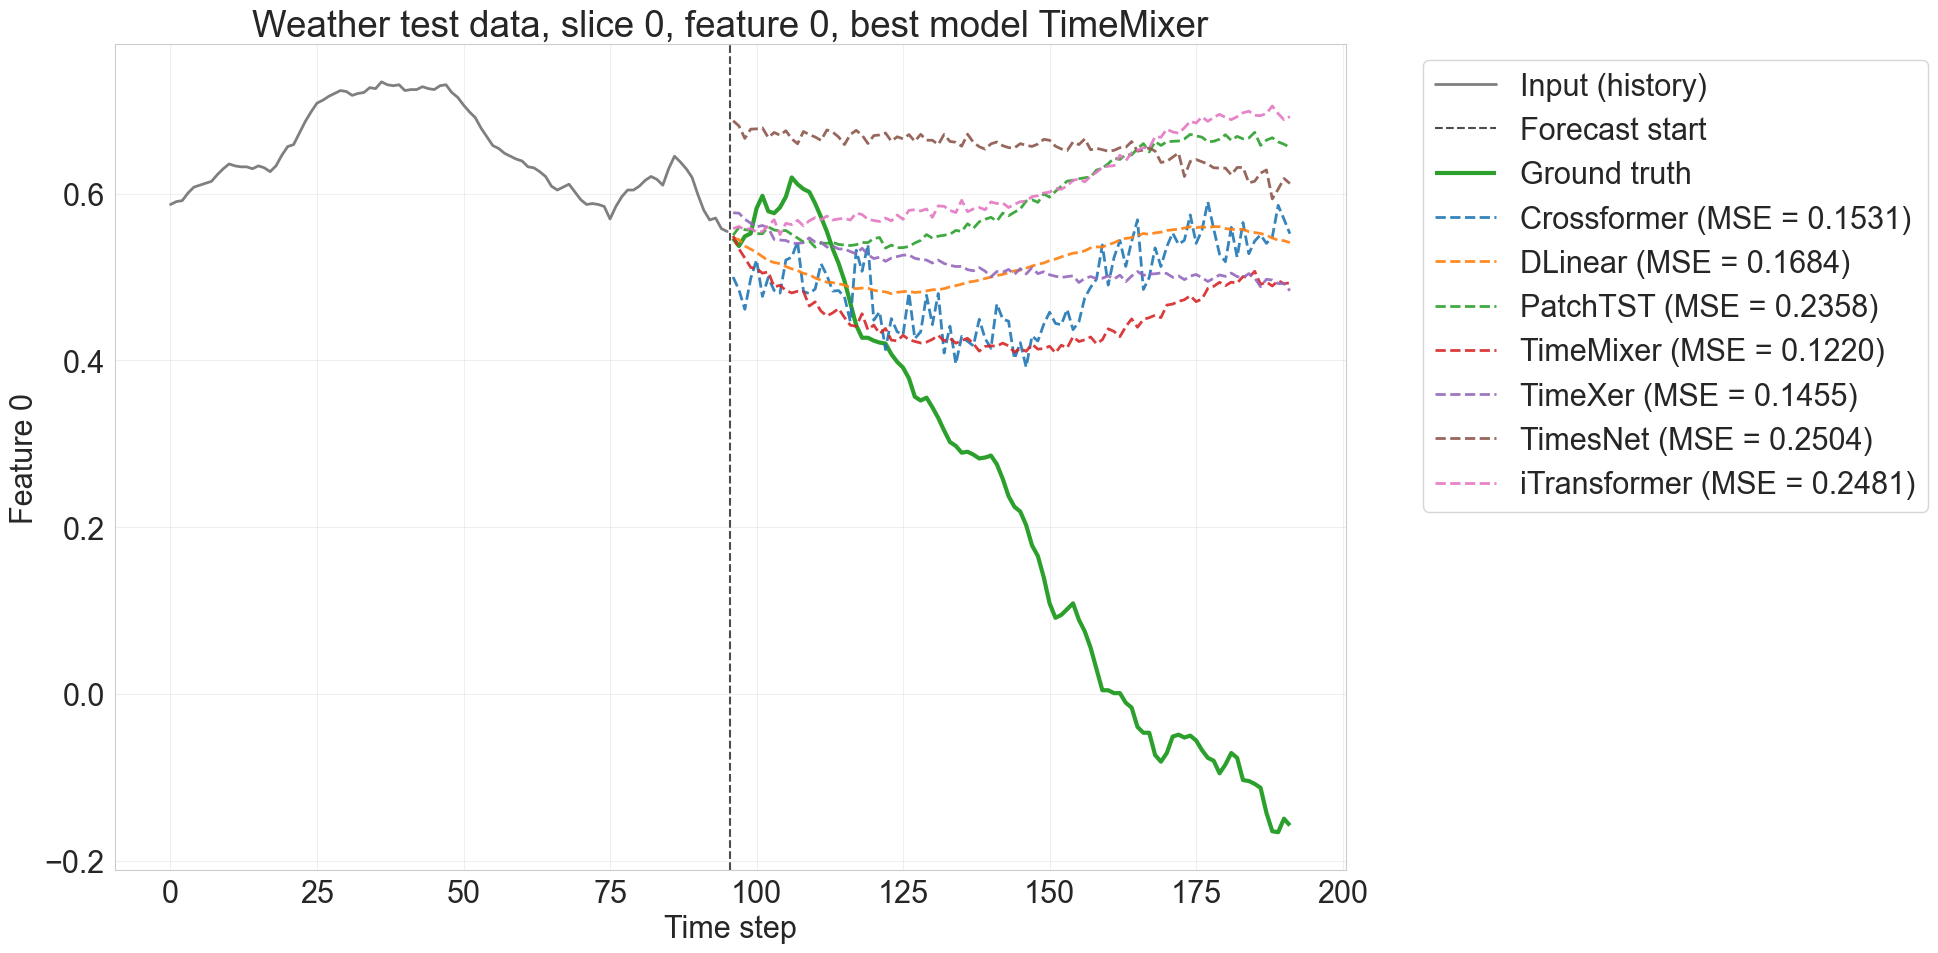

In [62]:
plot_slice_preds(weather_test_data, 0, 0)

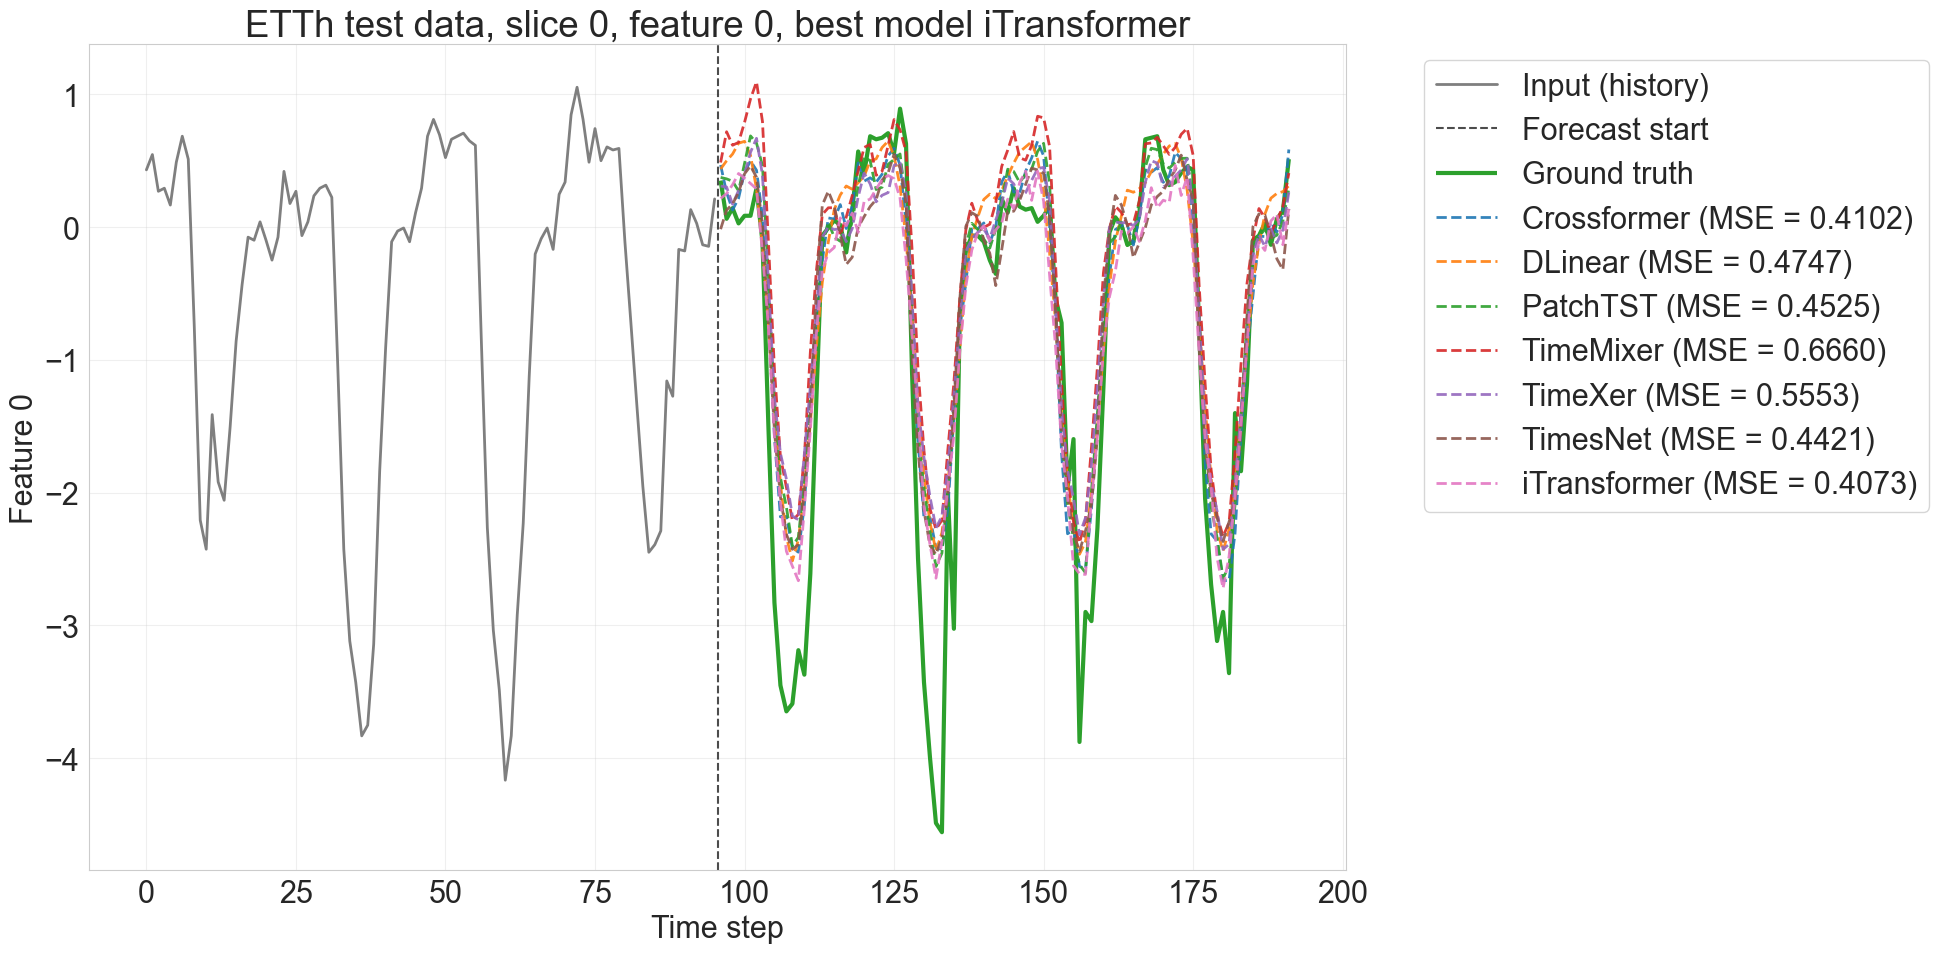

In [63]:
plot_slice_preds(ett_test_data, 0, 0)

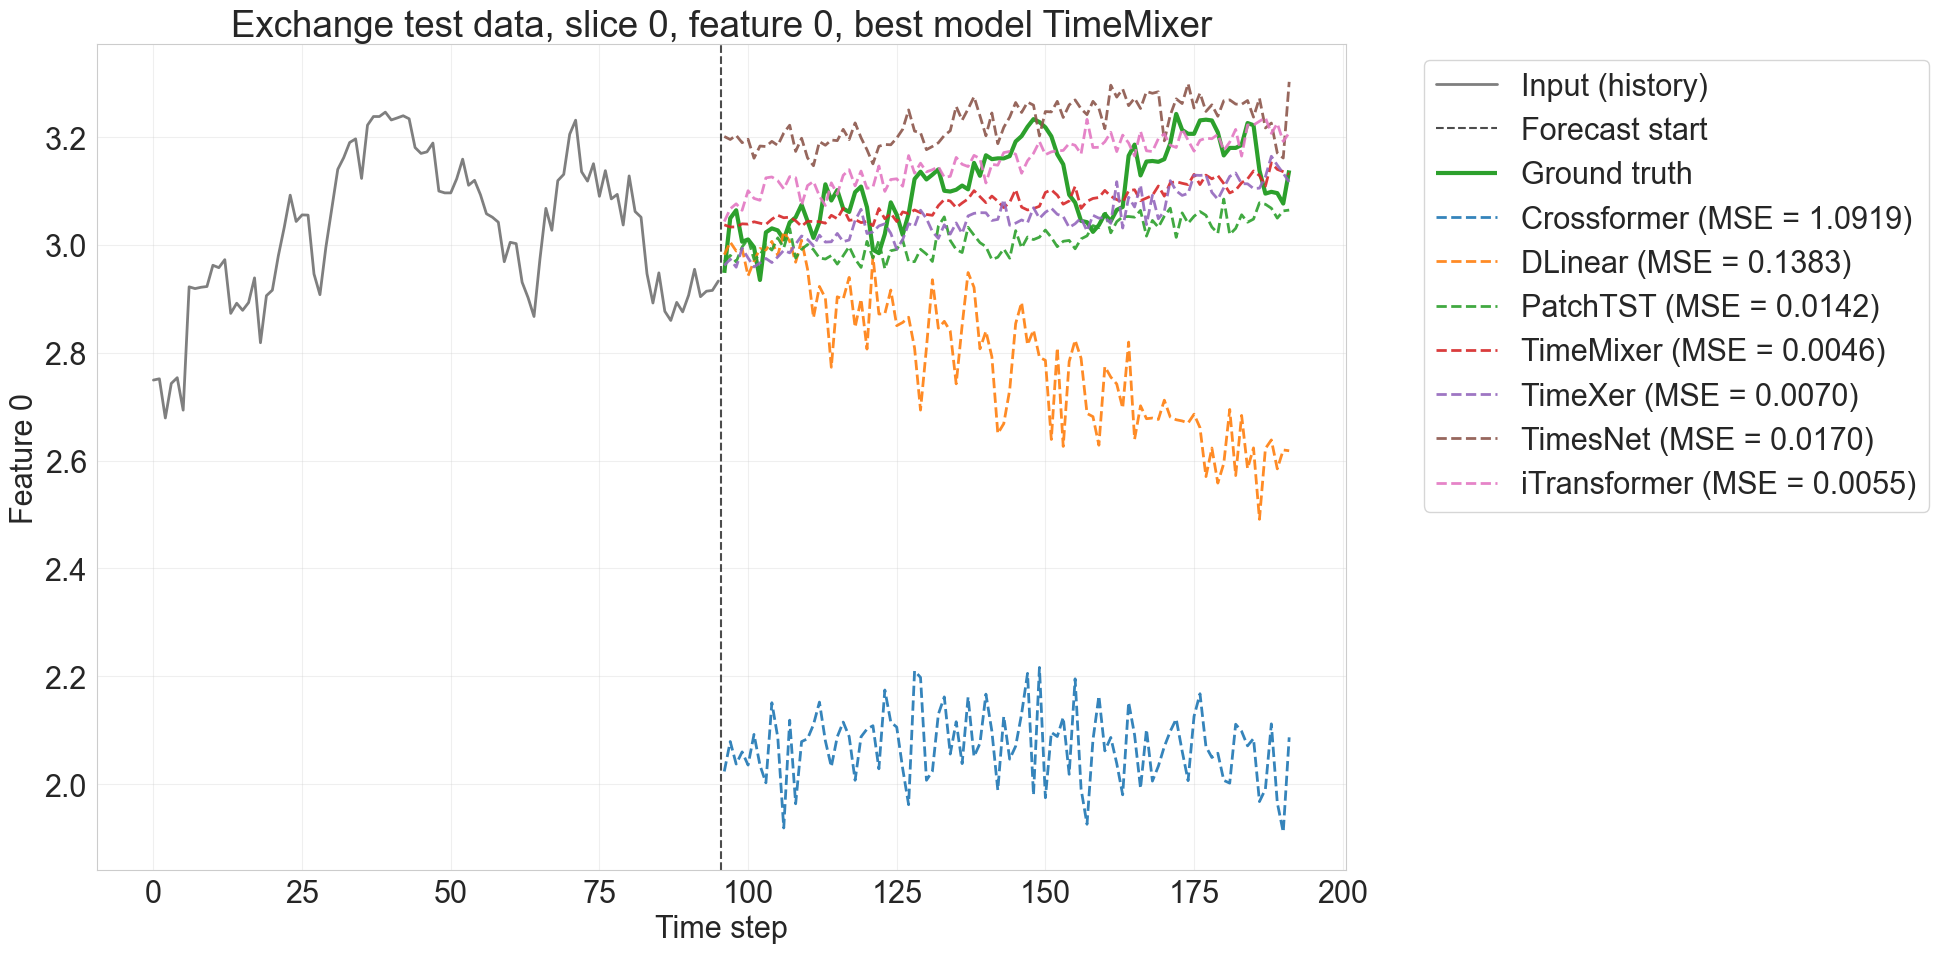

In [64]:
plot_slice_preds(exchange_test_data, 0, 0)

In [65]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image, display


def gif_forecasts(cls_data: CLSData, feature_idx=0, fps=5, max_frames=250):
    n_slices = cls_data.x.shape[0]
    frames = min(n_slices, max_frames)
    indices = np.linspace(0, n_slices - 1, frames, dtype=int)

    inp_all = cls_data.x[:, :, feature_idx]
    out_all = cls_data.y[:, :, feature_idx]
    preds_all = cls_data.preds[:, :, :, feature_idx]
    mse_all = ((preds_all - out_all) ** 2).mean(axis=2)

    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    fig = plt.figure()
    ax = fig.add_axes([0.12, 0.12, 0.60, 0.76])

    def animate(i):
        ax.clear()

        slice_idx = indices[i]
        inp = inp_all[slice_idx]
        out = out_all[slice_idx]
        preds = preds_all[:, slice_idx, :]
        mse_per_model = mse_all[:, slice_idx]

        best_idx = cls_data.best_idx[slice_idx, feature_idx]
        best_model = cls_data.id2label[best_idx]

        t_in = np.arange(len(inp))
        t_out = np.arange(len(inp), len(inp) + len(out))

        ax.plot(t_in, inp, color='tab:gray',
                linewidth=2, label='Input (history)')
        ax.axvline(len(inp) - 0.5, color='black', linestyle='--', alpha=0.7)
        ax.plot(t_out, out, color='tab:green', linewidth=3,
                label='Ground truth', solid_capstyle='butt')

        for j in range(preds.shape[0]):
            label = f'{cls_data.id2label[j]} (MSE = {mse_per_model[j]:.4f})'
            ax.plot(t_out, preds[j], color=colors[j], linestyle='--', linewidth=2,
                    label=label, alpha=0.9)

        ax.set_xlabel('Time step')
        ax.set_ylabel(f'Feature {feature_idx}')
        ax.set_title(
            f'Slice {slice_idx} – Feature {feature_idx}\nBest model: {best_model}')
        ax.grid(True, alpha=0.3)

        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    anim = animation.FuncAnimation(
        fig, animate, frames=frames, interval=1000//fps)
    anim.save('forecasts.gif', writer=PillowWriter(fps=fps), dpi=110)
    plt.close(fig)
    display(Image('forecasts.gif'))

In [66]:
# gif_forecasts(weather_test_data, feature_idx=0, max_frames=300)

In [67]:
# gif_forecasts(ett_test_data, feature_idx=0, max_frames=300)

In [68]:
# gif_forecasts(exchange_test_data, feature_idx=0, max_frames=300)

<h2> Summarizing performance: Global and per-slice </h2>

In [ ]:
def add_model_to_cls_data(preds: np.ndarray, model_name: str, cls_data: CLSData) -> CLSData:
    new_preds = np.concatenate((preds[None, :, :, :], cls_data.preds))
    new_model_mse = ((cls_data.y - preds)**2).mean(1)
    new_mse = np.concatenate((new_model_mse[None, :, :], cls_data.mse))
    new_best_idx = new_mse.argmin(0)
    # Shift existing keys up by 1 and add new model at key 0
    new_id2label = {k + 1: v for k, v in cls_data.id2label.items()}
    new_id2label[0] = model_name
    return CLSData(cls_data.x, cls_data.y, new_preds, new_mse, new_best_idx, new_id2label, f"{cls_data.name} + {model_name}")

def select_preds_from_idx(idx: np.ndarray, preds: np.ndarray):
    _, _, n_time, _ = preds.shape
    idx_reshaped = idx[np.newaxis, :, np.newaxis, :]
    A_broadcastable = np.repeat(idx_reshaped, n_time, axis=2)
    result_take = np.take_along_axis(preds, A_broadcastable, axis=0)
    output = np.squeeze(result_take, axis=0)
    return output

In [70]:
def print_metrics_matrix(cls_data: CLSData, include_oracle=True) -> str:
    if include_oracle:
        oracle_preds = select_preds_from_idx(cls_data.best_idx, cls_data.preds)
        cls_data = add_model_to_cls_data(oracle_preds, "Oracle", cls_data)

    mse = ((cls_data.y[None, :, :, :]-cls_data.preds)**2).mean(axis=(1, 2, 3))
    mae = (np.abs(cls_data.y[None, :, :, :]-cls_data.preds)).mean(axis=(1, 2, 3))
    id2label = cls_data.id2label

    header = f"{'Model':<15} {'MSE':>10} {'MAE':>10}"
    sep = "-"*37
    lines = [header, sep]

    idx_sorted = mse.argsort()
    for i in idx_sorted:
        name = id2label[i]
        lines.append(f"{name:<15} {mse[i]:10.4f} {mae[i]:10.4f}")

    print("\n".join([cls_data.name + " metrics"] + lines))

In [71]:
print_metrics_matrix(weather_test_data)
print_metrics_matrix(ett_test_data)
print_metrics_matrix(exchange_test_data)

Weather test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.1161     0.1595
TimeXer             0.1574     0.2047
TimeMixer           0.1623     0.2096
TimesNet            0.1690     0.2195
Crossformer         0.1743     0.2391
PatchTST            0.1749     0.2167
iTransformer        0.1753     0.2159
DLinear             0.1962     0.2561
ETTh test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.3184     0.3629
TimeMixer           0.3779     0.3992
PatchTST            0.3783     0.3984
TimeXer             0.3818     0.4029
TimesNet            0.3890     0.4120
iTransformer        0.3950     0.4098
DLinear             0.3962     0.4108
Crossformer         0.4063     0.4372
Exchange test data + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.0436     0.1422
TimeXer             0.0

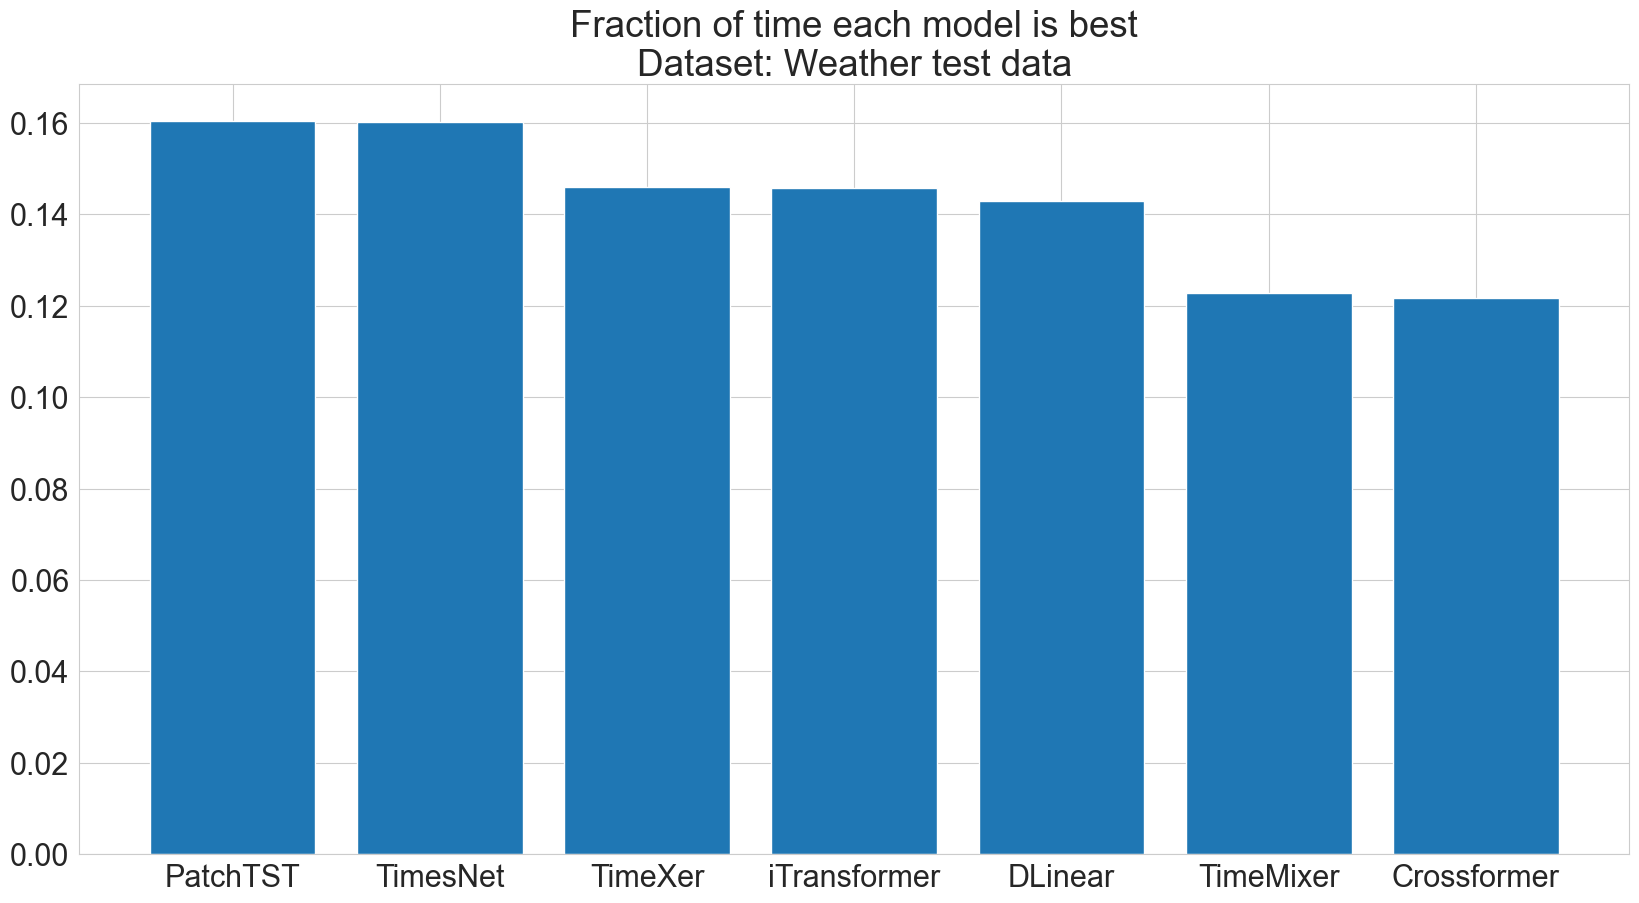

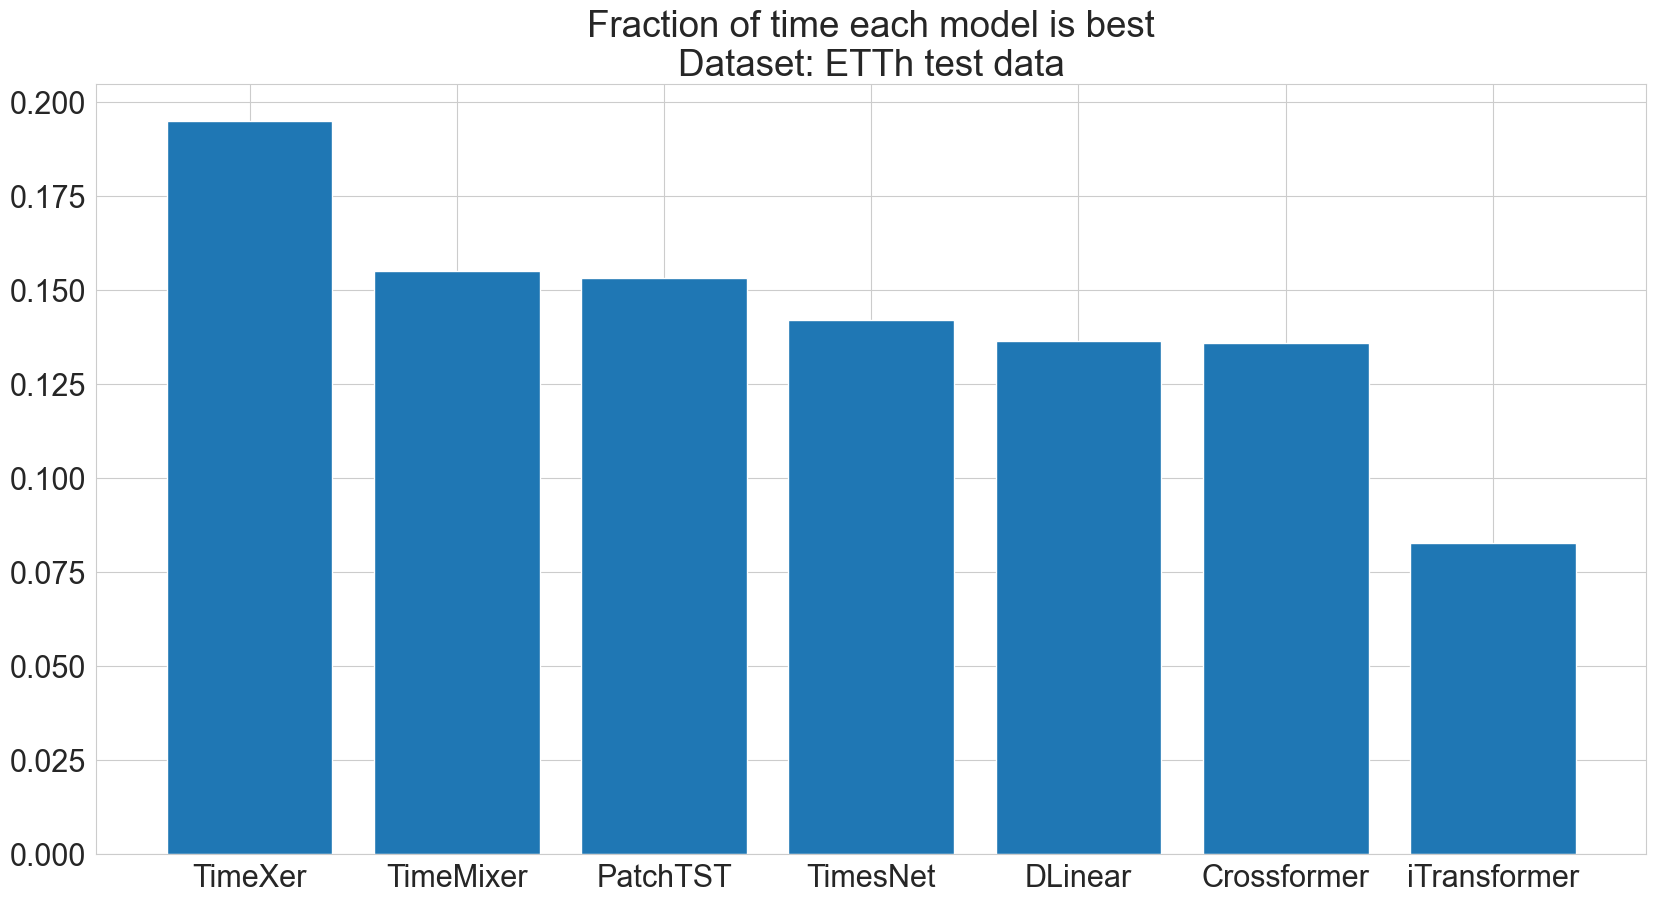

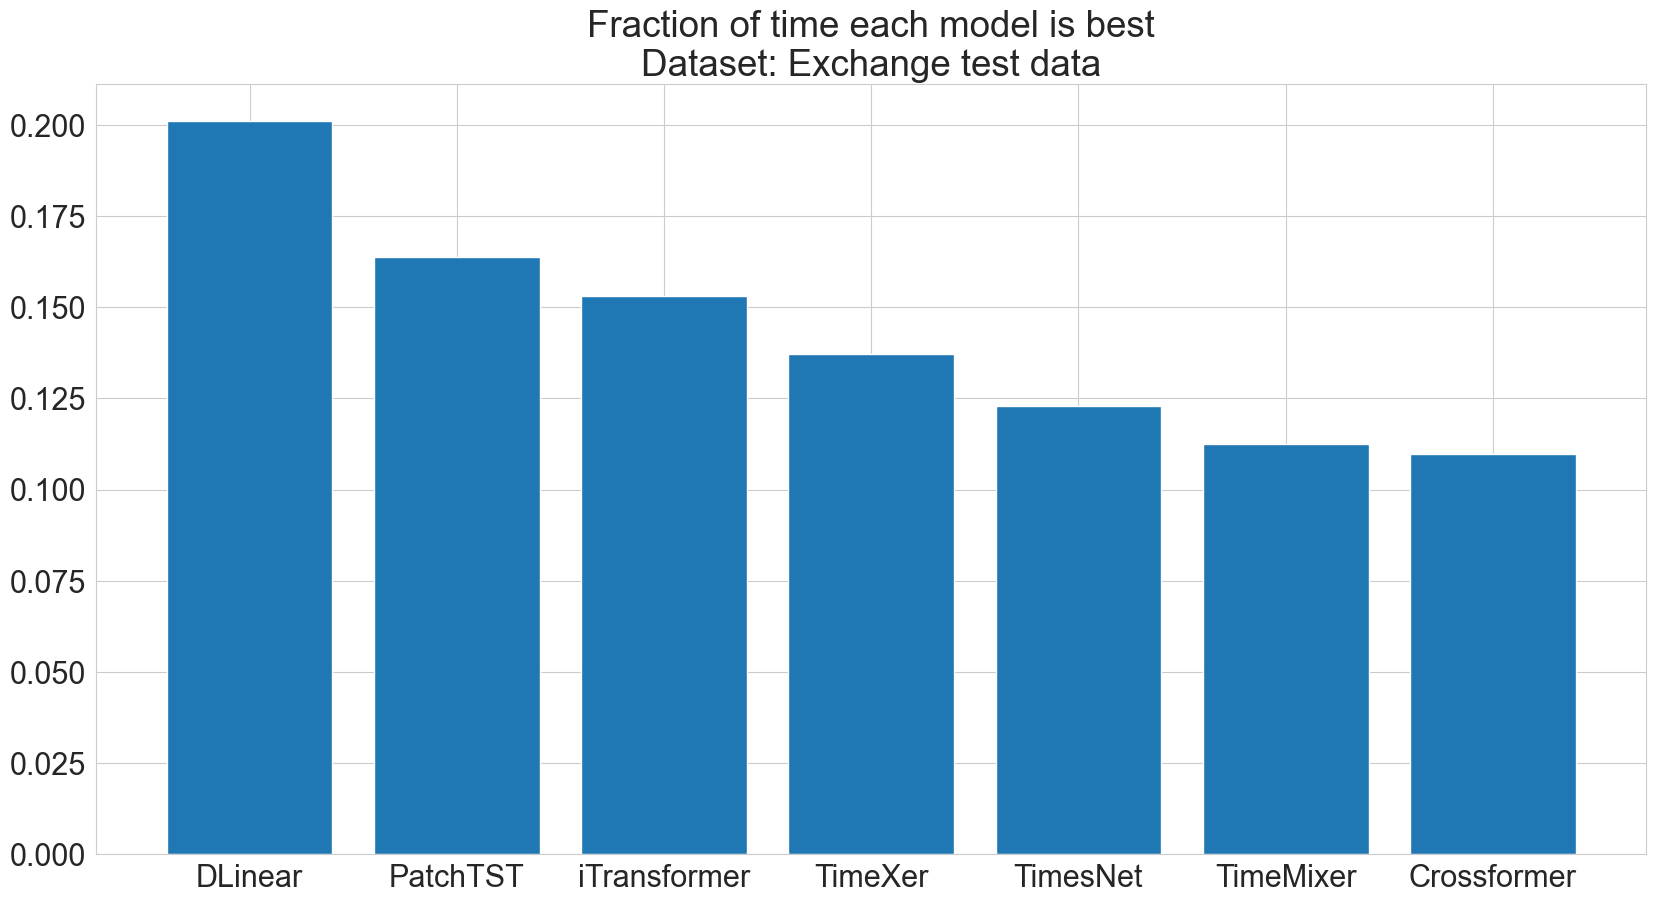

In [72]:
def plot_mse_per_slice(cls_data: CLSData) -> None:
    mse = cls_data.mse
    top_mse = np.argmin(mse.reshape(len(mse), -1), axis=0)
    vals, counts = np.unique(top_mse, return_counts=True)
    fracs = counts / len(top_mse)
    sort_idx = np.argsort(-fracs)
    vals = vals[sort_idx]
    fracs = fracs[sort_idx]
    labels = [cls_data.id2label[i] for i in vals]
    plt.title(f"Fraction of time each model is best\nDataset: {cls_data.name}")
    plt.bar(labels, fracs)
    plt.show()

plot_mse_per_slice(weather_test_data)
plot_mse_per_slice(ett_test_data)
plot_mse_per_slice(exchange_test_data)

<h2> Classifying the best model with Rocket</h2>

In [73]:
from sktime.classification.kernel_based import RocketClassifier
from sklearn.metrics import classification_report


@dataclass
class CLSOutput:
    predicted_best: np.ndarray
    routed_forecasts: np.ndarray


def run_rocket(train_data: CLSData, val_data: CLSData, test_data: CLSData) -> Tuple[CLSOutput, CLSOutput, CLSOutput]:

    def _reshape_cls_data(cls_data: CLSData):
        n_slices, seq_len, n_feats = cls_data.x.shape
        x_rs = cls_data.x.transpose(0, 2, 1).reshape(n_slices*n_feats, seq_len)
        idx_rs = cls_data.best_idx.reshape(n_slices*n_feats)
        return x_rs, idx_rs

    rocket = RocketClassifier(num_kernels=150)
    X_train, y_train = _reshape_cls_data(train_data)
    rocket.fit(X_train, y_train)

    X_val, y_val = _reshape_cls_data(val_data)
    X_test, y_test = _reshape_cls_data(test_data)
    val_preds = rocket.predict(X_val)
    test_preds = rocket.predict(X_test)

    val_report = classification_report(y_val, val_preds)
    test_report = classification_report(y_test, test_preds)

    def _create_cls_output(preds: np.ndarray, cls_data: CLSData):
        n_slices, _, n_feats = cls_data.x.shape
        predicted_best_idx = preds.reshape(n_slices, n_feats)
        routed_forecasts = select_preds_from_idx(predicted_best_idx, cls_data.preds)
        return CLSOutput(predicted_best_idx, routed_forecasts)

    val_output = _create_cls_output(val_preds, val_data)
    test_output = _create_cls_output(test_preds, test_data)

    # val_output_proba = _create_cls_output_proba(val_preds_proba, val_data)
    # test_output_proba = _create_cls_output_proba(test_preds_proba, test_data)

    print(f"====VAL REPORT====\n{val_report}\n\n")
    print(f"====TEST REPORT====\n{test_report}\n\n")

    return val_output, test_output


print("WEATHER")
rocket_val_output_weather, rocket_test_output_weather = run_rocket(weather_train_data, weather_val_data, weather_test_data)
print("ETT")
rocket_val_output_ett, rocket_test_output_ett = run_rocket(ett_train_data, ett_val_data, ett_test_data)
print("EXCHANGE")
rocket_val_output_exchange, rocket_test_output_exchange = run_rocket(exchange_train_data, exchange_val_data, exchange_test_data)

WEATHER
(108675,) (108675, 7)
(219324,) (219324, 7)
====VAL REPORT====
              precision    recall  f1-score   support

           0       0.29      0.05      0.09     11407
           1       0.23      0.17      0.20     12965
           2       0.71      0.31      0.43     17232
           3       0.28      0.28      0.28     15202
           4       0.21      0.07      0.11     16128
           5       0.23      0.56      0.33     19832
           6       0.22      0.28      0.25     15909

    accuracy                           0.27    108675
   macro avg       0.31      0.25      0.24    108675
weighted avg       0.32      0.27      0.25    108675



====TEST REPORT====
              precision    recall  f1-score   support

           0       0.27      0.05      0.08     26707
           1       0.23      0.18      0.20     31364
           2       0.69      0.32      0.44     35189
           3       0.19      0.19      0.19     26938
           4       0.21      0.09      

In [74]:
weather_test_data_with_rocket = add_model_to_cls_data(
    rocket_test_output_weather.routed_forecasts, "Rocket", weather_test_data)
ett_test_data_with_rocket = add_model_to_cls_data(
    rocket_test_output_ett.routed_forecasts, "Rocket", ett_test_data)
exchange_test_data_with_rocket = add_model_to_cls_data(
    rocket_test_output_exchange.routed_forecasts, "Rocket", exchange_test_data)

In [75]:
print("WEATHER")
print_metrics_matrix(weather_test_data_with_rocket)
print("ETT")
print_metrics_matrix(ett_test_data_with_rocket)
print("EXCHANGE")
print_metrics_matrix(exchange_test_data_with_rocket)

WEATHER
Weather test data + Rocket + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.1161     0.1595
TimeXer             0.1574     0.2047
TimeMixer           0.1623     0.2096
Rocket              0.1649     0.2145
TimesNet            0.1690     0.2195
Crossformer         0.1743     0.2391
PatchTST            0.1749     0.2167
iTransformer        0.1753     0.2159
DLinear             0.1962     0.2561
ETT
ETTh test data + Rocket + Oracle metrics
Model                  MSE        MAE
-------------------------------------
Oracle              0.3184     0.3629
TimeMixer           0.3779     0.3992
PatchTST            0.3783     0.3984
TimeXer             0.3818     0.4029
Rocket              0.3869     0.4115
TimesNet            0.3890     0.4120
iTransformer        0.3950     0.4098
DLinear             0.3962     0.4108
Crossformer         0.4063     0.4372
EXCHANGE
Exchange test data + Rocket + Oracle metrics
Model        

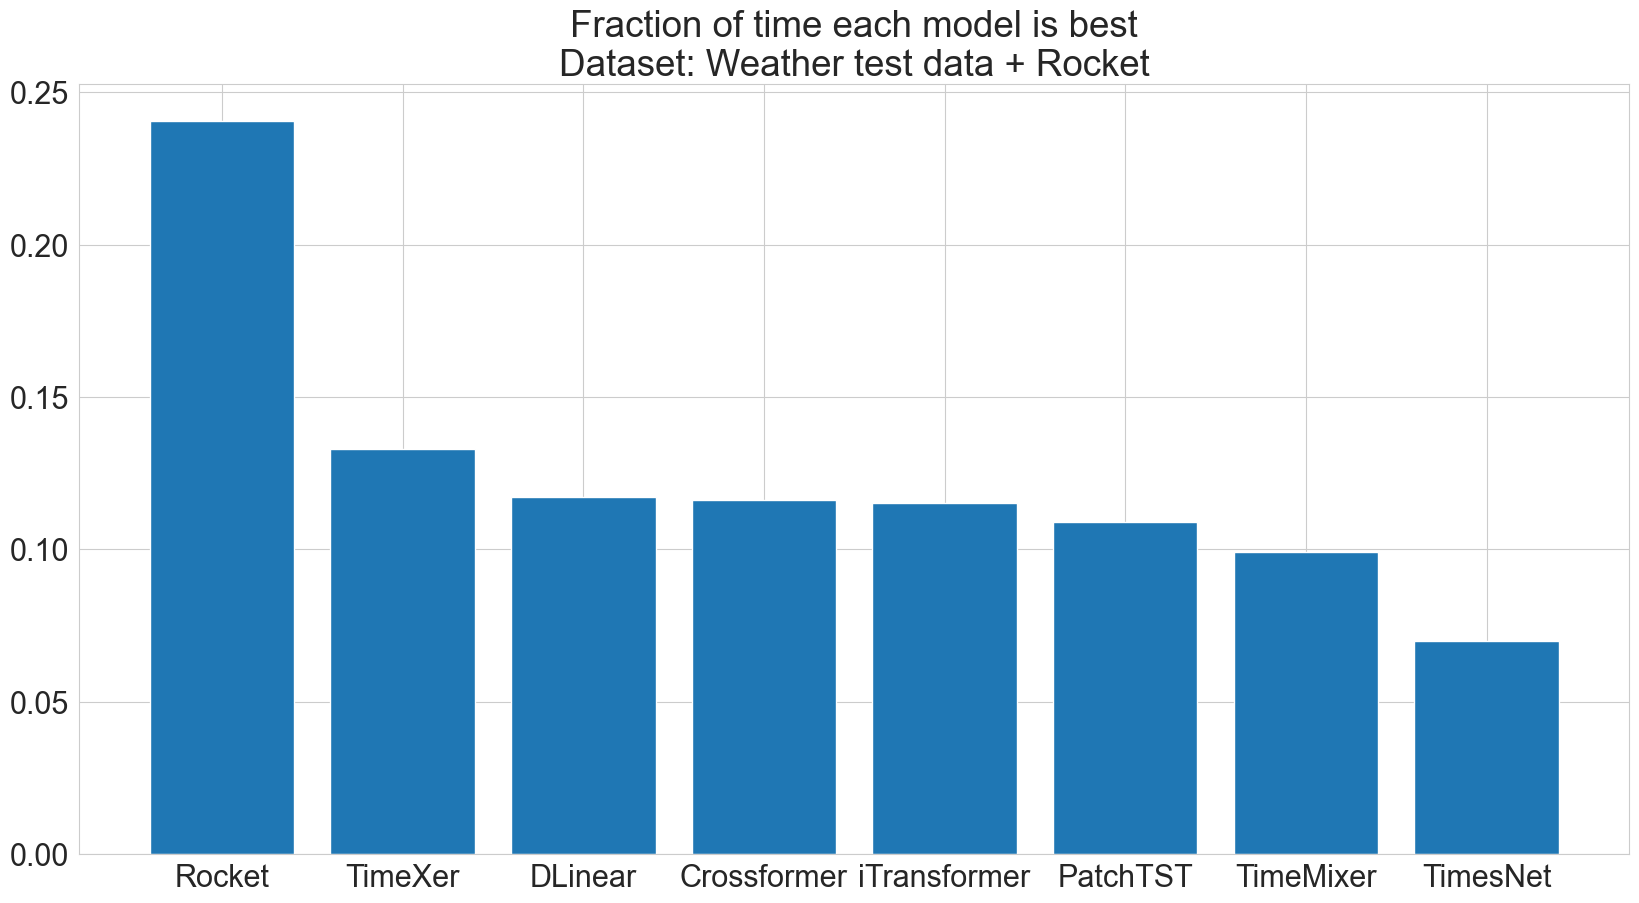

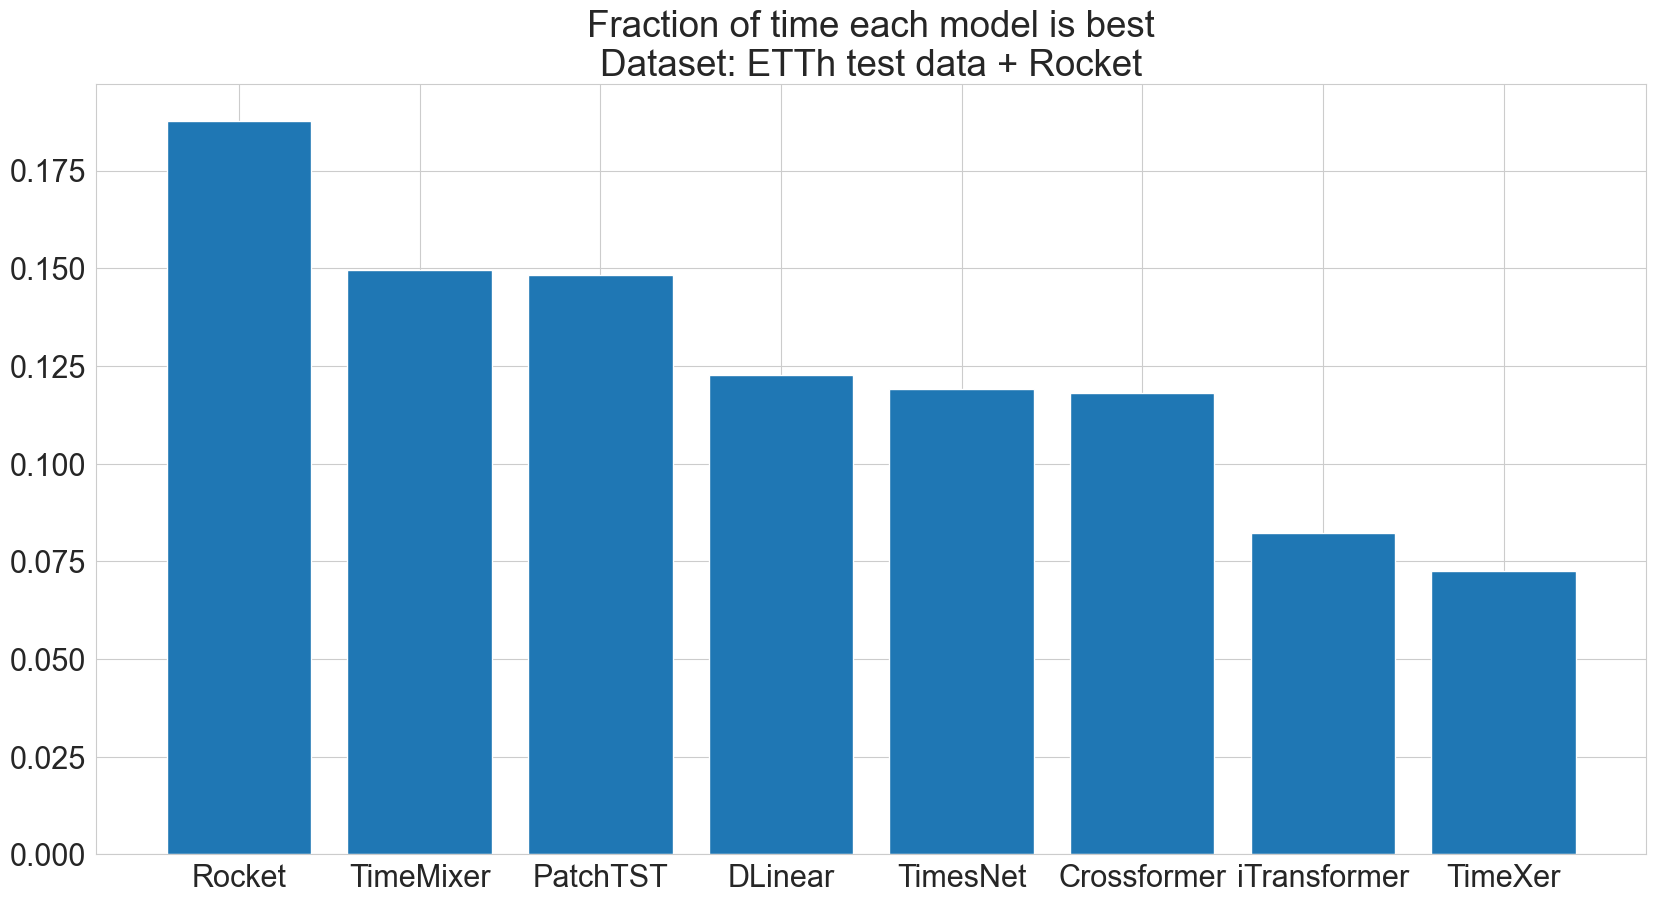

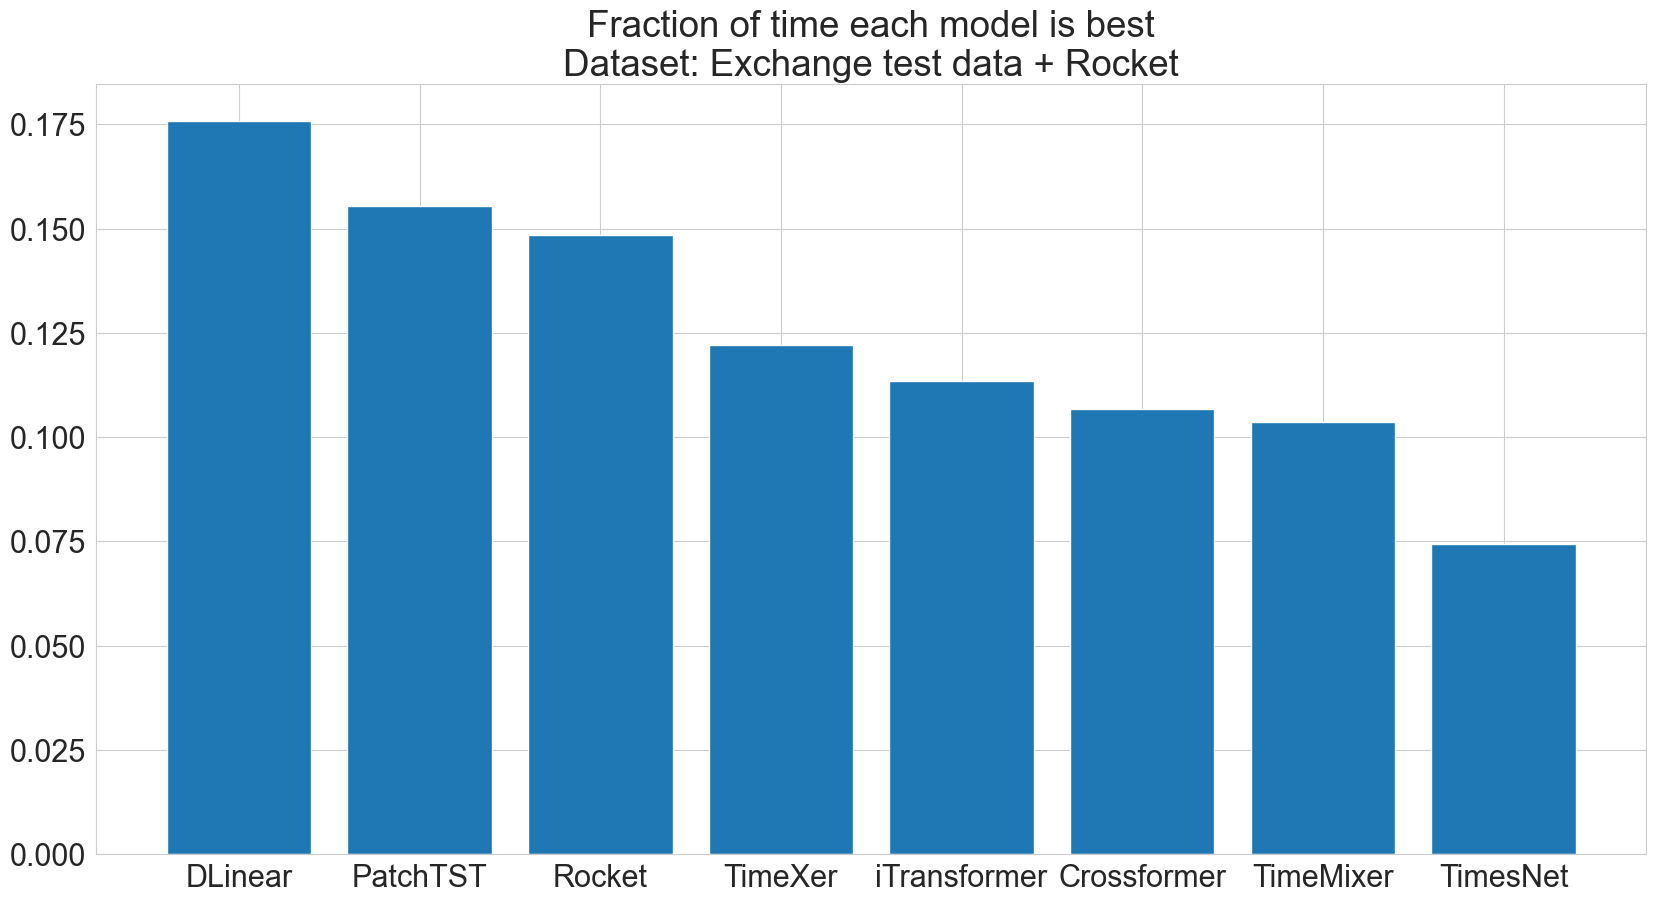

In [76]:
plot_mse_per_slice(weather_test_data_with_rocket)
plot_mse_per_slice(ett_test_data_with_rocket)
plot_mse_per_slice(exchange_test_data_with_rocket)

<h2> Embedding the models </h2>

In [78]:
from openai import OpenAI
from tsrouter.secrets import OPENAI_API_KEY

def create_model_embeddings() -> np.ndarray:
    client = OpenAI(api_key=OPENAI_API_KEY)
    embeddings_dict = {}
    with open(data_path / "model_strings.json") as f:
        model_strings = json.load(f)

    for k, v in model_strings.items():
        response = client.embeddings.create(
            input=f"{k}\n\n{v}",
            model="text-embedding-3-small"
        )
        embeddings_dict[k] = np.array(response.data[0].embedding)

    return embeddings_dict

model_embeddings = create_model_embeddings()
model_embeddings["Crossformer"].shape

(1536,)

<h2> Embedding the time series </h2>

<h3> VQVAE </h3>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from vector_quantize_pytorch import VectorQuantize


class ResidualConv1D(nn.Module):

    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            drop: float = 0.1,
            norm: bool = True
    ):
        super().__init__()

        padding = (kernel_size - 1) // 2

        self.block = nn.Sequential(
            nn.Conv1d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding),
            nn.ReLU(),
            nn.Conv1d(out_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding),
            nn.Dropout(drop)
        )

        self.norm = nn.BatchNorm1d(out_channels) if norm else nn.Identity()
        self.rs = nn.Conv1d(in_channels, out_channels,
                            1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):

        return self.norm(self.block(x) + self.rs(x))


class Normalize(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        x = x.permute(0, 2, 1)
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        x = x.permute(0, 2, 1)
        return x

    def _init_params(self):
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(
            torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


@dataclass
class VQVAEConfig:
    in_channels: int
    seq_len: int
    codebook_size: int
    embedding_dim: int
    high_compression: int


@dataclass
class VQVAEOutput:
    loss: torch.Tensor
    mse: torch.Tensor
    rec: torch.Tensor
    latents: torch.Tensor
    e_loss: torch.Tensor
    z_q: torch.Tensor


class VQVAE(nn.Module):

    def __init__(self, config: VQVAEConfig):
        super().__init__()

        self.config = config
        self.in_channels = config.in_channels
        self.seq_len = config.seq_len
        self.codebook_size = config.codebook_size
        self.embedding_dim = config.embedding_dim
        self.norm = Normalize(1, affine=False)

        self.encoder = nn.Sequential(
            ResidualConv1D(1, 32, 5, 1),
            nn.Conv1d(32, 64, 3, 2, 1),
            ResidualConv1D(64, 64, 5, 1),
            nn.Conv1d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.MaxPool1d(2) if config.high_compression else nn.Identity(),
            nn.Conv1d(128, self.embedding_dim, 1)
        )

        self.quantizer = VectorQuantize(
            dim=self.embedding_dim,
            codebook_size=self.codebook_size,
            use_cosine_sim=True
        )

        self.decoder = nn.Sequential(
            nn.Conv1d(self.embedding_dim, 128, 1),
            nn.Upsample(
                scale_factor=2) if config.high_compression else nn.Identity(),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, 3, 2, 1, 1),
            ResidualConv1D(64, 64, 5, 1),
            nn.ConvTranspose1d(64, 32, 3, 2, 1, 1),
            ResidualConv1D(32, 1, 5, 1),
        )

    def get_codebook(self):
        return self.quantizer.codebook

    def decode_from_latents(self, latents: torch.LongTensor) -> torch.Tensor:
        z_q = self.quantizer.get_output_from_indices(latents)
        z_q = z_q.permute(0, 2, 1)
        xhat = self.decoder(z_q)
        xhat = xhat.reshape(-1, self.in_channels, self.seq_len)
        xhat = self.norm(xhat, mode="denorm")

        return xhat

    def decode_from_codebook_distribution(self, logits: torch.Tensor) -> torch.Tensor:
        assert logits.shape[-1] == self.codebook_size
        codes = torch.einsum("bnd,dk->bnk", logits, self.quantizer.codebook)
        proj_codes = self.quantizer.project_out(codes)
        z_q = proj_codes.permute(0, 2, 1)
        xhat = self.decoder(z_q)
        xhat = xhat.reshape(-1, self.in_channels, self.seq_len)
        xhat = self.norm(xhat, mode="denorm")
        return xhat

    def forward(
            self,
            x: torch.Tensor,
            lambda_rec: float = 1,
            lambda_temp: float = 1,
            lambda_reg: float = 0.01) -> VQVAEOutput:

        x_ = self.norm(x, mode="norm")
        x_ = x_.reshape(-1, 1, self.seq_len)

        z = self.encoder(x_)
        z = z.permute(0, 2, 1)

        z_q, idx, e_loss = self.quantizer(z)
        z_q = z_q.permute(0, 2, 1)

        xhat_ = self.decoder(z_q)
        xhat_ = xhat_.reshape(-1, self.in_channels, self.seq_len)
        xhat = self.norm(xhat_, mode="denorm")

        mse_loss = F.mse_loss(x, xhat)

        temp_loss = F.mse_loss(
            x[:, :, 1:] - x[:, :, :-1],
            xhat[:, :, 1:] - xhat[:, :, :-1]
        )

        loss = lambda_rec * mse_loss + lambda_reg * \
            e_loss.mean() + lambda_temp * temp_loss

        return VQVAEOutput(
            loss=loss,
            mse=mse_loss,
            rec=xhat,
            latents=idx,
            e_loss=e_loss,
            z_q=z_q
        )

In [ ]:
print(weather_train_data.preds.shape)

(7, 36696, 96, 21)


In [79]:
from torch.utils.data import Dataset, DataLoader

class CLSTorchDataset(Dataset):
    def __init__(self, cls_data: CLSData):
        self.cls_data = cls_data
        self.n_models, self.n_slices, self.seq_len, self.n_feats = cls_data.preds.shape
        self.flat_x = cls_data.x.transpose(0, 2, 1).reshape(self.n_slices * self.n_feats, self.seq_len)
        self.flat_y = cls_data.y.transpose(0, 2, 1).reshape(self.n_slices * self.n_feats, self.seq_len)
        self.flat_preds = cls_data.preds.transpose(0, 1, 3, 2).reshape(self.n_models, self.n_slices * self.n_feats, self.seq_len)
        self.flat_best_idx = cls_data.best_idx.flatten()
        self.flat_mse = cls_data.mse.transpose(0, 2, 1).reshape(self.n_slices * self.n_feats, self.n_models)

    def __len__(self):
        return len(self.flat_x)

    def __getitem__(self, idx: int):
        relevance = self.flat_mse[idx].shape[-1] - self.flat_mse[idx].argsort(-1).argsort(-1)
        return {
            "x": self.flat_x[idx, None],
            "y": self.flat_y[idx, None],
            "preds": self.flat_preds[:, idx, None],
            "best_idx": self.flat_best_idx[idx],
            "mse": self.flat_mse[idx],
            "relevance": relevance
        }


dataset = CLSTorchDataset(weather_train_data)
sample = dataset[20]
print(sample["x"].shape, sample["y"].shape, sample["preds"].shape, sample["best_idx"].shape, sample["mse"].shape, sample["relevance"].shape)

(1, 96) (1, 96) (7, 1, 96) () (7,) (7,)


In [ ]:
import json
import torch
import colorama
from tqdm import tqdm
from dataclasses import dataclass


@dataclass
class ReconstructionArgs:
    lr: float
    num_epochs: int
    batch_size: int
    out_dir: Path = Path("vqvae_results")


def plot_recs(inp: torch.Tensor, out_rec: torch.Tensor, out_dir: Path, n_plots: int = 5):
    out_dir.mkdir(parents=True, exist_ok=True)
    batch_size, n_feats, seq_len = inp.shape
    n_plots = min(n_plots, batch_size)
    sample_indices = np.random.choice(batch_size, size=n_plots, replace=False)

    if isinstance(inp, torch.Tensor):
        inp = inp.cpu().numpy()
    if isinstance(out_rec, torch.Tensor):
        out_rec = out_rec.cpu().numpy()

    n_cols = min(3, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    _, axes = plt.subplots(n_rows, n_cols)
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    time_steps = np.arange(seq_len)

    for idx, sample_idx in enumerate(sample_indices):
        ax = axes[idx]
        feature_idx = np.random.randint(0, n_feats)
        gt_series = inp[sample_idx, feature_idx, :]
        rec_series = out_rec[sample_idx, feature_idx, :]
        mse = np.mean((gt_series - rec_series) ** 2)

        ax.plot(time_steps, gt_series, 'g-', linewidth=2,
                label='Ground Truth', alpha=0.8)
        ax.plot(time_steps, rec_series, 'r--', linewidth=2,
                label='Reconstructed', alpha=0.8)

        ax.set_xlabel('Time step')
        ax.set_ylabel(f'Feature {feature_idx}')
        ax.set_title(
            f'Sample {sample_idx}, Feature {feature_idx}\nMSE: {mse:.4f}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(out_dir / f"rec_sample_{idx}.png")



class VQVAEExperiment:

    def __init__(
        self, 
        args: ReconstructionArgs, 
        vqvae_config: VQVAEConfig,
        train_data: CLSData, 
        val_data: CLSData, 
        test_data: CLSData):

        colorama.init()
        self.num_epochs = args.num_epochs
        self.batch_size = args.batch_size
        self.lr = args.lr
        self.device = "mps"
        self.config = args
        self.out_dir = args.out_dir

        self.model = VQVAE(vqvae_config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        self.train_data = CLSTorchDataset(train_data)
        self.val_data = CLSTorchDataset(val_data)
        self.test_data = CLSTorchDataset(test_data)

        self.train_loader = DataLoader(self.train_data, batch_size=args.batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=args.batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_data, batch_size=args.batch_size, shuffle=False)

        self.best_val_loss = float("inf")
        self.model_dir = self.out_dir / "best_model"
        self.model_dir.mkdir(parents=True, exist_ok=True)
        self.model_config_path = self.model_dir / "model_config.json"
        self.best_model_path = self.model_dir / "best_model.pt"


    def run(self):
        train_losses = []
        train_mse_losses = []
        val_losses = []
        val_mse_losses = []

        for epoch in range(1, self.num_epochs + 1):

            print(f"\nEPOCH {epoch}/{self.num_epochs}\n{'='*10}")
            epoch_dir = self.out_dir / f"epoch_{epoch}"
            epoch_dir.mkdir(parents=True, exist_ok=True)

            self.model.train()
            train_loss = 0
            train_mse = 0
            pbar = tqdm(self.train_loader, desc="Training")

            for sample in pbar:
                series = sample["x"].to(self.device)
                out: VQVAEOutput = self.model(series)

                loss = out.loss
                mse = out.mse

                train_loss += loss.item()
                train_mse += mse.item()

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                pbar.set_description(f"Loss: {loss.item():.4f}, MSE: {mse.item():.4f}")

            current_train_loss = train_loss / len(self.train_loader)
            current_train_mse = train_mse / len(self.train_loader)

            val_loss, val_mse = self.evaluate(self.val_loader, epoch_dir)
            current_val_loss = val_loss
            current_val_mse = val_mse

            train_losses.append(current_train_loss)
            train_mse_losses.append(current_train_mse)

            val_losses.append(current_val_loss)
            val_mse_losses.append(current_val_mse)

            print(f"Train Loss: {current_train_loss}, "
                  f"MSE: {current_train_mse}")
            print(f"Val Loss: {current_val_loss}, "
                  f"MSE: {current_val_mse}")

            if current_val_loss < self.best_val_loss:
                self.best_val_loss = current_val_loss
                torch.save(self.model.state_dict(), self.best_model_path)
                print("Saved new best model!")

            self.lr_scheduler.step(current_val_loss)

        history = {
            "train_loss": train_losses,
            "train_mse": train_mse_losses,
            "val_loss": val_losses,
            "val_mse": val_mse_losses
        }

        with open(self.out_dir / "training_history.json", "w") as f:
            json.dump(history, f)

        self.model.load_state_dict(torch.load(self.best_model_path))
        test_loss, test_mse = self.evaluate(self.test_loader, self.out_dir / "test")

        test_metrics = {
            "test_loss": test_loss,
            "test_mse": test_mse,
            "best_val_loss": self.best_val_loss,
            "n_epochs_trained": epoch,
        }

        with open(self.out_dir / "test_metrics.json", "w") as f:
            json.dump(test_metrics, f, indent=4)

        self.save_latents()


    def evaluate(self, data_loader, out_dir) -> ReconstructionArgs:
        self.model.eval()
        loss, mse = 0, 0

        with torch.no_grad():
            for i, sample in enumerate(tqdm(data_loader, desc="Evaluating")):
                series = sample["x"].to(self.device)
                out: VQVAEOutput = self.model(series)

                loss += out.loss.item()
                mse += out.mse.item()

                if i == 0:
                    plot_recs(series, out.rec, out_dir, 6)

        loss /= len(data_loader)
        mse /= len(data_loader)

        return loss, mse

    def save_latents(self):
        self.model.eval()
        train_latents, val_latents, test_latents = [], [], []

        # Redefine the train loader to avoid shuffling
        train_loader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=False)
        with torch.no_grad():
            for sample in tqdm(train_loader, desc="Saving train latents"):
                series = sample["x"].to(self.device)
                out: VQVAEOutput = self.model(series)
                train_latents.append(out.latents.cpu().numpy())
            for sample in tqdm(self.val_loader, desc="Saving val latents"):
                series = sample["x"].to(self.device)
                out: VQVAEOutput = self.model(series)
                val_latents.append(out.latents.cpu().numpy())
            for sample in tqdm(self.test_loader, desc="Saving test latents"):
                series = sample["x"].to(self.device)
                out: VQVAEOutput = self.model(series)
                test_latents.append(out.latents.cpu().numpy())

        train_latents = np.concatenate(train_latents)
        val_latents = np.concatenate(val_latents)
        test_latents = np.concatenate(test_latents)
        np.save(self.out_dir / "train_latents.npy", train_latents)
        np.save(self.out_dir / "val_latents.npy", val_latents)
        np.save(self.out_dir / "test_latents.npy", test_latents)
        codebook = self.model.get_codebook().cpu().numpy()
        np.save(self.out_dir / "codebook.npy", codebook)


vqvae_config = VQVAEConfig(
    in_channels=1,
    seq_len=weather_train_data.x.shape[1],
    codebook_size=1024,
    embedding_dim=128,
    high_compression=False
)

weather_exp = VQVAEExperiment(
    ReconstructionArgs(
        lr=0.001,
        num_epochs=10,
        batch_size=128,
        out_dir=Path("vqvae_results") / "weather"
    ), vqvae_config, weather_train_data, weather_val_data, weather_test_data)


# weather_exp.run()

<h2> Ranking the multi-modal embeddings with a Transformer </h2> 

In [ ]:
def model_embeddings_to_torch(model_embeddings: Dict[str, np.ndarray], freeze: bool = True) -> nn.Embedding:
    embeddings = torch.stack([torch.Tensor(v) for v in model_embeddings.values()])
    embedding = nn.Embedding.from_pretrained(embeddings, freeze=freeze)
    return embedding

In [ ]:
weather_torch_dataset = CLSTorchDataset(weather_train_data)
weather_train_loader = DataLoader(weather_torch_dataset, batch_size=128, shuffle=True)
batch = next(iter(weather_train_loader))

In [ ]:
class CrossAttention(nn.Module):

    def __init__(self, d: int, num_heads: int, dropout: float):
        super().__init__()
        self.W_q = nn.Linear(d, d)
        self.W = nn.Linear(d, 2*d)
        self.proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(d)

        self.num_heads = num_heads
        self.scale = (d // num_heads) ** -0.5

    def forward(self, x: torch.Tensor, x_q: torch.Tensor) -> torch.Tensor:
        q = self.W_q(x_q)
        k, v = self.W(x).chunk(2, dim=-1)

        b, s, d = x.shape
        _, s_q, _ = q.shape

        q = q.reshape(b, s_q, self.num_heads, d//self.num_heads).transpose(1, 2)
        k, v = (z.reshape(b, s, self.num_heads, d//self.num_heads).transpose(1, 2)
                   for z in (k, v))

        attn = torch.einsum("bhqd,bhkd->bhqk", q, k) * self.scale
        attn_weights = F.softmax(attn, dim=-1)

        attn_logits = attn_weights @ v
        out = self.proj(attn_logits.transpose(1, 2).contiguous().view(b, s_q, d))
        out = self.dropout(out)

        return self.norm(x_q + out)


class MultiHeadAttention(nn.Module):

    def __init__(
            self,
            d,
            num_heads=4):
        super().__init__()

        self.num_heads = num_heads
        self.W = nn.Linear(d, 3*d)
        self.proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(0.2)
        self.norm = nn.LayerNorm(d)

        self.scale = (d // num_heads) ** -0.5

    def forward(self, x):

        b, s, d = x.shape
        q, k, v = self.W(x).chunk(3, dim=-1)
        q, k, v = (z.reshape(b, s, self.num_heads, d//self.num_heads).transpose(1, 2)
                   for z in (q, k, v))

        attn = torch.einsum("bhqd,bhkd->bhqk", q, k) * self.scale
        attn_weights = F.softmax(attn, dim=-1)

        attn_logits = attn_weights @ v
        out = self.proj(attn_logits.transpose(1, 2).contiguous().view(b, s, d))
        out = self.dropout(out)

        return self.norm(x + out)


class MLP(nn.Module):

    def __init__(self, d):
        super().__init__()

        self.norm = nn.LayerNorm(d)
        self.mlp = nn.Sequential(
            nn.Linear(d, d),
            nn.ReLU(),
            nn.Linear(d, d),
            nn.Dropout(0.2)
        )

    def forward(self, x):

        return self.norm(self.mlp(x) + x)

@dataclass
class TransformerConfig:
    d_model: int
    num_heads: int
    dropout: float
    num_layers: int


class MultiModalTransformer(nn.Module):

    def __init__(self, config: TransformerConfig, vqvae: VQVAE, model_embeddings: Dict[str, np.ndarray]):
        super().__init__()
        self.config = config
        self.vqvae = vqvae

        self.model_embeddings = model_embeddings_to_torch(model_embeddings, freeze=True)
        self.time_series_embeddings = nn.Embedding(self.vqvae.codebook_size, self.config.d_model)

        for param in self.vqvae.parameters():
            param.requires_grad = False

        self.pos_embed = nn.Embedding(
            self.vqvae.seq_len // (8 if self.vqvae.config.high_compression else 4), 
            self.config.d_model
        )

        self.vqvae_proj = nn.Linear(self.vqvae.embedding_dim, self.config.d_model) if self.vqvae.embedding_dim != self.config.d_model else nn.Identity()
        self.model_proj = nn.Linear(self.model_embeddings.weight.shape[1], self.config.d_model) if self.model_embeddings.weight.shape[1] != self.config.d_model else nn.Identity()

        self.cross_attn = CrossAttention(self.config.d_model, self.config.num_heads, self.config.dropout)
        self.mlp = MLP(self.config.d_model)

        self.transformer = nn.ModuleList([
            nn.Sequential(
                MultiHeadAttention(self.config.d_model, self.config.num_heads),
                MLP(self.config.d_model),
            )
            for _ in range(self.config.num_layers)
        ])

        self.transformer = nn.Sequential(*self.transformer)

        self.out_proj = nn.Linear(self.config.d_model, 1)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Get embeddings of time series and models, project to d_model if needed
        # cross attention model embeddings with time series embeddings
        # n_layers transformer blocks
        # compute score for each model
        ts_idx = self.vqvae(x).latents
        z_ts = self.time_series_embeddings(ts_idx) # self.vqvae(x).z_q.permute(0, 2, 1)
        z_ts = z_ts + self.pos_embed.weight[None, :, :]
        z_model = self.model_embeddings.weight[None, :, :].repeat(x.shape[0], 1, 1)

        z_ts = self.vqvae_proj(z_ts)
        z_model = self.model_proj(z_model)

        z = self.cross_attn(z_ts, z_model)
        z = self.mlp(z)
        z = self.transformer(z)

        return self.out_proj(z).squeeze(-1)


multi_modal_transformer_config = TransformerConfig(
    d_model=128,
    num_heads=4,
    dropout=0.2,
    num_layers=1
)

vqvae = VQVAE(vqvae_config)
vqvae.load_state_dict(torch.load("vqvae_results/weather/best_model/best_model.pt"))
transformer = MultiModalTransformer(multi_modal_transformer_config, vqvae, model_embeddings)
logits = transformer(batch["x"])
logits.shape

torch.Size([128, 7])

In [ ]:
class SimpleModel(nn.Module):

    def __init__(self, d_model: int, seq_len: int, n_models: int):
        super().__init__()
        self.seq_len = seq_len
        self.n_models = n_models
        self.norm = Normalize(1, affine=False)

        self.network = nn.Sequential(
            nn.Linear(seq_len, d_model),
            MLP(d_model),
            nn.Linear(d_model, n_models)
        )

    def forward(self, x):
        # Run MLP on time series directly to predict the best model
        x_ = x.reshape(-1, 1, self.seq_len)
        x_ = self.norm(x_, mode="norm")
        # x_ = x_.reshape(-1, 1, self.seq_len)
        return self.network(x_).squeeze(1)


simple_model = SimpleModel(256, 96, 7)
# logits = simple_model(batch["x"])
# logits.shape

In [ ]:
def logistic_loss(scores: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    mask = torch.where(labels[:, :, None] - labels[:, None, :] > 0, 1, 0)
    diffs = scores[:, :, None] - scores[:, None, :]
    losses = mask * torch.log(1 + torch.exp(-diffs))
    return losses.mean()

# TODO: Implement LambdaRankLoss


scores = torch.tensor([[1,2,3]])
labels = torch.tensor([[1,4,5]])
print(scores.shape, labels.shape)
logistic_loss(scores, labels)

torch.Size([1, 3]) torch.Size([1, 3])


tensor(0.0837)

In [ ]:
from sklearn.metrics import classification_report


@dataclass
class ModelRankingArgs:
    lr: float
    n_epochs: int
    batch_size: int
    out_dir: Path = Path("ranking_results")


class ModelRankingExperiment:
    def __init__(self, args: ModelRankingArgs, model: MultiModalTransformer, train_data: CLSData, val_data: CLSData, test_data: CLSData):
        self.args = args
        self.model = model
        self.train_data = CLSTorchDataset(train_data)
        self.val_data = CLSTorchDataset(val_data)
        self.test_data = CLSTorchDataset(test_data)
        self.train_loader = DataLoader(
            self.train_data, batch_size=args.batch_size, shuffle=True)
        self.val_loader = DataLoader(
            self.val_data, batch_size=args.batch_size, shuffle=False)
        self.test_loader = DataLoader(
            self.test_data, batch_size=args.batch_size, shuffle=False)

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, "min", patience=10, factor=0.1)

    def run(self):
        train_losses = []
        val_losses = []
        for epoch in range(self.args.n_epochs):
            print(f"EPOCH {epoch+1}")
            self.model.train()
            train_loss = 0
            pbar = tqdm(self.train_loader, desc="Training")
            for batch in pbar:
                x = batch["x"].to(self.device)
                y = batch["y"].to(self.device)
                preds = batch["preds"].to(self.device)
                # relevance = batch["relevance"].to(self.device)
                # mse = batch["mse"].to(self.device)
                # print(preds.shape, y.shape)
                mse = ((preds - y[:, None, :, :])**2).mean((2,3))
                # print(mse[0])
                relevance = torch.max(mse, dim=-1)[0][:, None] -  mse# .shape[-1] - mse.argsort(-1).argsort(-1)
                # print(relevance[0])

                # print(mse[0], mse_comp[0])

                # print(x.shape, y.shape, preds.shape, relevance.shape, mse.shape)
                # plt.plot(x[0, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), y[0, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 0, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 1, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 2, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 3, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 4, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 5, 0, :].detach().cpu().numpy())
                # plt.plot(torch.arange(96, 2*96), preds[0, 6, 0, :].detach().cpu().numpy())
                # plt.show()

                logits = self.model(x)

                assert logits.ndim==2 and relevance.ndim==2
                loss = logistic_loss(logits, relevance)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

            val_loss, val_labels, val_preds = 0, [], []
            with torch.no_grad():
                self.model.eval()
                for batch in tqdm(self.val_loader, desc="Validating"):
                    x = batch["x"].to(self.device)
                    # relevance = batch["relevance"].to(self.device)
                    preds = batch["preds"].to(self.device)
                    y = batch["y"].to(self.device)
                    logits = self.model(x)

                    mse = ((preds - y[:, None, :, :])**2).mean((2,3))
                    relevance = torch.max(mse, dim=-1)[0][:, None] - mse

                    assert logits.ndim == 2 and relevance.ndim == 2
                    loss = logistic_loss(logits, relevance)
                    # loss = self.loss_fn(logits.squeeze(1), labels)

                    val_loss += loss.item()
                    val_labels += relevance.argmax(-1).detach().cpu().tolist()
                    val_preds += logits.argmax(-1).detach().cpu().tolist()

            train_loss /= len(self.train_loader)
            val_loss /= len(self.val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Train Loss: {train_loss}, Val Loss: {val_loss}")
            report = classification_report(val_labels, val_preds)
            print(report)


multi_modal_transformer_config = TransformerConfig(
    d_model=128,
    num_heads=4,
    dropout=0.1,
    num_layers=0
)
vqvae = VQVAE(vqvae_config)
vqvae.load_state_dict(torch.load(
    "vqvae_results/weather/best_model/best_model.pt"))
transformer = MultiModalTransformer(
    multi_modal_transformer_config, vqvae, model_embeddings)
weather_ranking_args = ModelRankingArgs(
    lr=0.001,
    n_epochs=10,
    batch_size=32,
    out_dir=Path("ranking_results") / "weather"
)
weather_ranking_exp = ModelRankingExperiment(
    weather_ranking_args, transformer, weather_train_data, weather_val_data, weather_test_data)
weather_ranking_exp.run()

EPOCH 1


Training:  15%|█▌        | 3707/24082 [05:04<50:32,  6.72it/s, loss=0.2855]

: 